## Generation of visual panoramas to be tested for head direction stability

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import vonmises
from skimage.morphology import disk
from scipy.signal import convolve2d, correlate
from scipy.stats import zscore

np.random.seed(seed=3)
%config Completer.use_jedi = False  #magic to fix autocomplete issue

### Visibility range of the screen
#### (a) Visibility below the horizon line
This visibility range is limited by the ball surface (unless the screen is very short)

In [24]:
ballRad = 4.6 # treadmill ball radius [mm]
flyEyeAboveBall = 1 # height of eye above ball surface [mm]

print('Angle visible below horizon line:')
90-(180/np.pi)*np.arcsin(ballRad/(flyEyeAboveBall+ballRad))

Angle visible below horizon line:


34.77194403194859

#### (b) Visibility above the horizon line
This visibility range is limited by either the fly holder (pyramid) or the screen height. 
If the screen is limited, the angle it spanns depends on the screen distannce  which may vary along the azimuth. We will consider only the extreme values, i.e. the minimum and maximum screen distances. For the pentagonal screen that r_min at the center of the faces and r_max at the corners. 

In [25]:
pyramidAngle = 20 #12 for old pyramid, ideally 20 for new pyramid

screenMinDist = 4.0 # cm
screenMaxDist = 5.5 #cm

topScreenHeight = 1.7 #cm

alpha_rmin = (180/np.pi) * np.arctan( topScreenHeight / screenMinDist)
alpha_rmax = (180/np.pi) * np.arctan( topScreenHeight / screenMaxDist)

print("The screen spands an angle from {} to {} above the horizon line.".format(alpha_rmax, alpha_rmin))

The screen spands an angle from 17.175903615746744 to 23.025492008528037 above the horizon line.


### Determine approrpiate size for the texture
Choose which angle should be spanned. The texture will be sized to be displayed such that it spanns the full size at the closes points on the  screen (r_min). Thus, the texture should be displayed on a cylinder with radius r_min.

In [39]:
setalpha = 20*(np.pi/180)
height_cm = np.round(np.arctan(setalpha) * screenMinDist, 2) * 2
# Values to set in unity scene:
print('Cylinder height: {}, Cylinder radius: {}'.format(height_cm/2, screenMinDist))

Cylinder height: 1.34, Cylinder radius: 4.0


In [46]:
pt_per_cm = 150
panHeight_px = int(height_cm * pt_per_cm)
panWidth_px = int(2*np.pi*screenMinDist*pt_per_cm)

maxBit = 255 #assuming 8bit image depth

dotSizeAng = 12 #aim for x deg dot

In [47]:
#panH = 34 + 5 # mm (2x visible screen height + some buffer)
#panR = 58 # mm, this should be the same as the max. distance of the screen from the fly (= face of pentagon)
#dpiVal = 1000

#panWidth_px = int(2*np.pi*panR*dpiVal/100)
#panHeight_px = int(panH*dpiVal/100)

## Stimuli with clear orientation information
Vary just the brightness and test on vs. off features
#### (1) Generate a sun spot and the inverse image 

In [ ]:
#covnert angular dot size to pixel size and make dot
dotRad = round(dotSizeAng/360 * panWidth_px * 1/2 )
mydot = disk(radius=dotRad)

dotpos_x = round(panWidth_px/2)
dotpos_y = round((panHeight_px + dotRad)/2)

pan = np.zeros((panWidth_px,panHeight_px),dtype=np.uint8)
pan[dotpos_x, dotpos_y] = maxBit
pan[:,:] = convolve2d(pan[:,:], mydot, boundary = 'wrap', mode='same')

pan = np.minimum(maxBit, pan)

In [ ]:
darkSpot = pan[:,:]
brightSpot = abs(maxBit - darkSpot)

In [ ]:
fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(darkSpot.T,origin='lower', cmap='Greys', vmin=0, vmax=maxBit)
fig.savefig("panoramas/darkSpot.tiff",dpi = dpiVal)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(brightSpot.T,origin='lower', cmap='Greys', vmin=0, vmax=maxBit)
fig.savefig("panoramas/brightSpot.tiff", dpi = dpiVal)

#### Generate two sun panoramas with matching overall brightness but opposide contrast

In [ ]:
panOn = darkSpot
panOff = maxBit-panOn
panOn = np.minimum(maxBit, panOn)
panOff = np.minimum(maxBit, panOff)

dotRatio = np.sum(panOn/maxBit)/(panWidth_px*panHeight_px)
panOn_shift = panOn/2 + (0.5-dotRatio*0.5)*maxBit
panOff_shift = panOff/2

In [ ]:
fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panOn_shift.T,origin='lower', cmap='Greys', vmin=0, vmax=maxBit)
fig.savefig("panoramas/darkOnGrey.tiff",dpi = 1000)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panOff_shift.T,origin='lower', cmap='Greys', vmin=0, vmax=maxBit)
fig.savefig("panoramas/brightOnGrey.tiff", dpi = 1000)

In [ ]:
print(np.sum(panOn))
print(np.sum(panOff))

print(np.sum(panOn_shift)/np.sum(panOff_shift))

**Follow up stimulus with darker grey background**

In [ ]:
panOn_dark = panOn_shift + 0.2*maxBit
panOff_dark = panOff_shift + 0.2*maxBit
panOn_dark = np.minimum(maxBit, panOn_dark)
panOff_dark[panOff_dark < 0.5*maxBit] = np.median(panOn_dark) - (maxBit - np.median(panOn_dark))

In [ ]:
fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panOn_dark.T,origin='lower', cmap='Greys', vmin=0, vmax=maxBit)
fig.savefig("panoramas/darkOnDarkGrey.tiff",dpi = 1000)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panOff_dark.T,origin='lower', cmap='Greys', vmin=0, vmax=maxBit)
fig.savefig("panoramas/brightOnDarkGrey.tiff", dpi = 1000)

In [ ]:
print(np.sum(panOn_dark)/np.sum(panOff_dark))

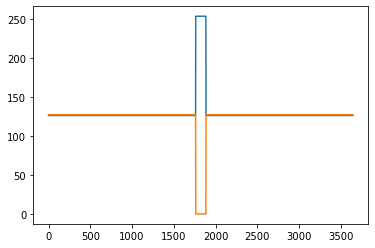

In [141]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

axs[0].plot(panOn_shift.T[dotpos_y,:])
axs[0].plot(panOff_shift.T[dotpos_y,:])
axs[0].set_title('Light and Dark on mid-range gray')
axs[0].set_ylim((0,maxBit))

axs[1].plot(panOn_dark.T[dotpos_y,:])
axs[1].plot(panOff_dark.T[dotpos_y,:])
axs[1].set_title('Light and Dark dark gray')
axs[1].set_ylim((0,maxBit))

#### (2) Generate a gradient

In [53]:
panGrad = np.tile( (np.sin(np.linspace(0,np.pi*2,panWidth_px)) + 1)*maxBit/2 ,panHeight_px).reshape(panHeight_px,panWidth_px)
panGradLow = np.tile( (np.sin(np.linspace(0,np.pi*2,panWidth_px)) + 2)*maxBit/4 ,panHeight_px).reshape(panHeight_px,panWidth_px)

panGradVeryLow = np.tile( (np.sin(np.linspace(0,np.pi*2,panWidth_px)) + 4)*maxBit/8 ,panHeight_px).reshape(panHeight_px,panWidth_px)

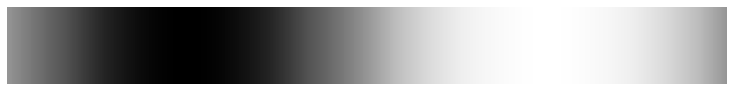

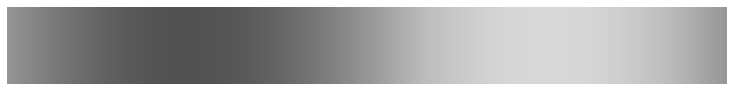

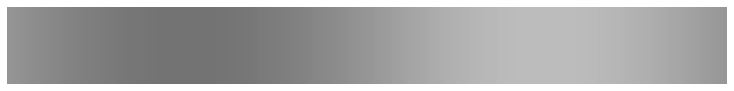

In [54]:
fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panGrad,origin='lower', cmap='Greys', vmin=0, vmax=maxBit)
fig.savefig("gradient.tiff",dpi = 1000)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panGradLow,origin='lower', cmap='Greys', vmin=0, vmax=maxBit)
fig.savefig("gradientLow.tiff",dpi = 1000)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panGradVeryLow,origin='lower', cmap='Greys', vmin=0, vmax=maxBit)
fig.savefig("gradientVeryLow.tiff",dpi = 1000)

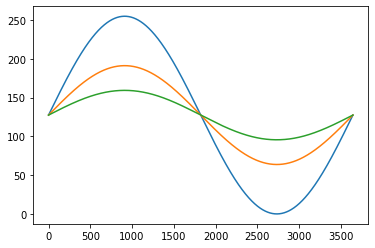

In [55]:
plt.plot(panGrad[0,:])
plt.plot(panGradLow[0,:])
plt.plot(panGradVeryLow[0,:])

## Test effect of feature size

In [56]:
kappa = 1.2 #shape parameter for von mieses
elevationrange = 40

numDots = [0,4,24]
dotSizeAng = 20 #aim for x deg dot

#covnert angular dot size to pixel size and make dot
dotRad = round(dotSizeAng/360 * panWidth_px * 1/2 )
mydot = disk(radius=dotRad)

In [41]:
dotpos = []
for cond, n in enumerate(numDots):
    # place one dot at center:
    pan[round(panWidth_px/2), round(panHeight_px/2), cond] = maxBit
    
    dotpos_x = ((vonmises.rvs(kappa, size=n) + np.pi) * panWidth_px/(2*np.pi)).astype('int')
    dotpos_y = (np.random.uniform(0.5-elevationrange/360,0.5+elevationrange/360, n) * 
                panHeight_px).astype('int')
    for c in range(numDots[cond]):
        pan[dotpos_x[c], dotpos_y[c], cond] = maxBit
    
    if n > 0:
        dotpos.append([ np.hstack((round(panWidth_px/2),dotpos_x)), 
                                    np.hstack((round(panHeight_px/2),dotpos_y)) ] )
    else:
        dotpos.append([round(panWidth_px/2),round(panHeight_px/2)])

In [55]:
numDots

array([ 4, 19, 99])

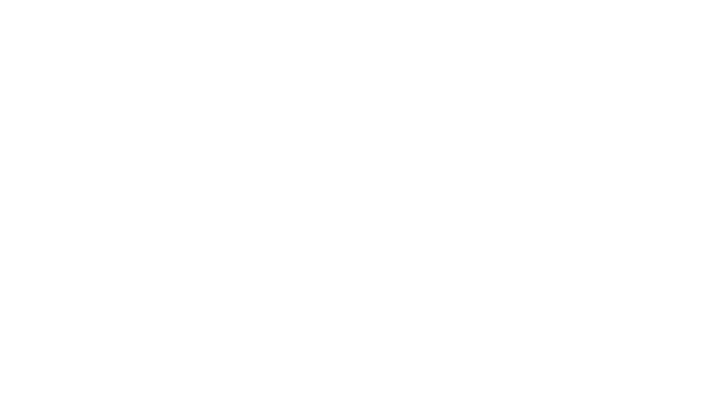

In [58]:
pan = np.zeros((panWidth_px,panHeight_px,len(numDots)),dtype=np.uint8)
panPlot = np.minimum(maxBit, pan)
panCorr = np.zeros((panWidth_px,panHeight_px,len(numDots)))

fig, axs = plt.subplots(len(numDots),2, figsize=(10,6))

for cond, n in enumerate(numDots):
    # place one dot at center:
    pan[round(panWidth_px/2), round(panHeight_px/2), cond] = maxBit
    
    dotpos_x = dotpos[cond][0]
    dotpos_y = dotpos[cond][1]
    for c in range(numDots[cond]):
        pan[dotpos_x[c], dotpos_y[c], cond] = maxBit
    pan[:,:,cond] = convolve2d(pan[:,:,cond], mydot, boundary = 'wrap', mode='same')
    
    panPlot_zsc = zscore(panPlot[:,:,cond].astype('float'), axis=None)
    panCorr[:,:,cond] = correlate(panPlot_zsc, panPlot_zsc, mode='same')
    axs[cond,0].imshow(panPlot[:,:,cond].T,origin='lower', cmap='Greys', vmin=0, vmax=maxBit)
    axs[cond,1].imshow(panCorr[:,:,cond].T,origin='lower', cmap='Greys')
    for ax in axs[cond,:]: ax.axis('off')
fig.tight_layout()

In [ ]:
smalldotSizeAng/dotSizeAng

In [ ]:
numSubDots = (np.asarray([1,4.75,24.75])*4).astype('int')
numSubDots

TypeError: 'int' object is not subscriptable

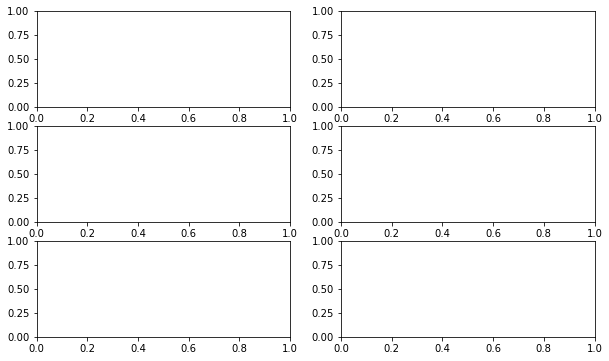

In [48]:
smalldotSizeAng = 5 
numSubDots = (np.asarray([1,4.75,24.75])*4).astype('int')

#covnert angular dot size to pixel size and make dot
dotRad = round(dotSizeAng/360 * panWidth_px * 1/2 )
mydot = disk(radius=dotRad)

pan2 = np.zeros((panWidth_px,panHeight_px,len(numDots)),dtype=np.uint8)
pan2Plot = np.minimum(maxBit, pan)
pan2Corr = np.zeros((panWidth_px,panHeight_px,len(numDots)))

fig, axs = plt.subplots(len(numDots),2, figsize=(10,6))

for cond, n in enumerate(numDots):
    # place one dot at center:
    pan2[round(panWidth_px/2), round(panHeight_px/2), cond] = maxBit
    
    dotpos_x = dotpos[cond][0]
    dotpos_y = dotpos[cond][1]
    for c in range(numDots[cond]):
        pan2[dotpos_x[c], dotpos_y[c], cond] = maxBit
    pan2[:,:,cond] = convolve2d(pan[:,:,cond], mydot, boundary = 'wrap', mode='same')
    
    pan2Plot_zsc = zscore(pan2Plot[:,:,cond].astype('float'), axis=None)
    pan2Corr[:,:,cond] = correlate(pan2Plot_zsc, pan2Plot_zsc, mode='same')
    axs[cond,0].imshow(pan2Plot[:,:,cond].T,origin='lower', cmap='Greys', vmin=0, vmax=maxBit)
    axs[cond,1].imshow(pan2Corr[:,:,cond].T,origin='lower', cmap='Greys')
    for ax in axs[cond,:]: ax.axis('off')

fig.tight_layout()   

In [44]:
for cond, n in enumerate(numDots):
    print(n+1)
    
    print('xpos = {}'.format(dotpos[cond][0]))
    print('ypos = {}'.format(dotpos[cond][1]))
    
    print("...")

1
xpos = 1200
ypos = 400
...
5
xpos = [1200 1318  815 1615 1031]
ypos = [400 459 342 353 340]
...
25
xpos = [1200 1208 1456  832 1998 1399 1640 1209 1285 1103 1113 1830  705  827
  390 1355 1361  635  977 1474 1698 2341  683 2080 1495]
ypos = [400 325 452 417 466 453 382 335 358 311 427 326 342 354 383 433 390 400
 327 371 347 442 314 420 435]
...


In [ ]:
numDots = [0,4,49]

kappa = 1.2 #shape parameter for von mieses

elevationrange = 40

#covnert angular dot size to pixel size and make dot
dotRad = round(dotSizeAng/360 * panWidth_px * 1/2 )
mydot = disk(radius=dotRad)

pan = np.zeros((panWidth_px,panHeight_px,len(numDots)),dtype=np.uint8)

for cond, n in enumerate(numDots):
    # place one dot at center:
    pan[round(panWidth_px/2), round(panHeight_px/2), cond] = maxBit
    
    dotpos_x = ((vonmises.rvs(kappa, size=n) + np.pi) * panWidth_px/(2*np.pi)).astype('int')
    dotpos_y = (np.random.uniform(0.5-elevationrange/360,0.5+elevationrange/360, n) * panHeight_px).astype('int')
    for c in range(numDots[cond]):
        pan[dotpos_x[c], dotpos_y[c], cond] = maxBit
    pan[:,:,cond] = convolve2d(pan[:,:,cond], mydot, boundary = 'wrap', mode='same')

In [ ]:
panPlot = np.minimum(maxBit, pan)
panCorr = np.zeros((panWidth_px,panHeight_px,len(numDots)))

fig, axs = plt.subplots(len(numDots),2, figsize=(10,6))

for cond, n in enumerate(numDots):
    panPlot_zsc = zscore(panPlot[:,:,cond].astype('float'), axis=None)
    panCorr[:,:,cond] = correlate(panPlot_zsc, panPlot_zsc, mode='same')
    axs[cond,0].imshow(panPlot[:,:,cond].T,origin='lower', cmap='Greys', vmin=0, vmax=maxBit)
    axs[cond,1].imshow(panCorr[:,:,cond].T,origin='lower', cmap='Greys')
    
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
for cond, n in enumerate(numDots):
    axs.plot(np.sum(panCorr[:,:,cond], axis=1), label='{} dots'.format(n+1))
axs.legend()